# CV Course Project: Assignment - Image Recognition

---

**Group:**
- Alumno 1: San Millan Rodrigues, Nadine (n.srodrigues@alumnos.upm.es)
- Alumno 2: Sukhorukova, Anastasia (anastasia.s@alumnos.upm.es)
- Alumno 3: Reyes Castro, Didier Yamil (didier.reyes.castro@alumnos.upm.es)

**Course:** Computer Vision (CV) - 2025/26

**Institution:** Polytechnic University of Madrid (UPM)

**Date:** January 2026

---

## Goals

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

## 0 Setup and Data Loading

### 0.1 Install and Import Required Libraries

In [ ]:
# !pip install tensorflow numpy rasterio scikit-learn matplotlib keras

Loading the necessary libraries.

In [2]:
# Python libraries
import uuid
import warnings
import json
import os
import math

# External libraries
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Rescaling, BatchNormalization, Dropout, LeakyReLU, Conv2D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


Check if GPU is available for training the models.

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 0.2 Load the Dataset & Image Loader

Before loading the dataset, set the path to the folder containing the images.

In [4]:
IMAGES_PATH = '/mnt/c/Users/didie/Desktop/main/MUIA/CV/Labs/Image_Recognition/xview_recognition/'

In [5]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [6]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [7]:
def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(IMAGES_PATH + filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [8]:
# Load database
json_file = IMAGES_PATH + 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [9]:
counts = dict.fromkeys(categories.values(), 0)
anns_dataset = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns_dataset.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [10]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

### 0.3 Setup

In [11]:
# Fix random seed for reproducibility
RANDOM_SEED = 42
def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
set_seed(RANDOM_SEED)

# Number of categories for classification
NUM_CATEGORIES = len(categories)

## 1 CNN Model

Taking the best ffNN model as a baseline, we designed and trained a Convolutional Neural Network (CNN) to improve the results.

---
### Log of Changes

- Model 1: Simplification of ffNN architecture to a CNN architecture -> RESULTS: Less training time, better validation accuracy.
  - 1 Conv2D layer (32 filters, 3x3 kernel) followed by a single Softmax Dense layer (1).
  - ReLU activation.
  - Adam optimizer (learning rate: 1e-4).
  - Epochs: 20
  - Batch: 16


### 1.1 Setup

In [12]:
train2, val2 = train_test_split(anns_dataset,
                                test_size=0.1, 
                                random_state=RANDOM_SEED, 
                                stratify=[obj.category for ann in anns_dataset for obj in ann.objects])
print('Number of training images: ' + str(len(train2)))
print('Number of validation images: ' + str(len(val2)))

Number of training images: 16871
Number of validation images: 1875


In [13]:
print('Compiling the model...')


# Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), 
# groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
# kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)

model = Sequential([
    Input(shape=(224, 224, 3)), # 224x224 images with 3 channels (RGB)
    Rescaling(1./255), # Rescale pixel values to [0, 1]

    # --- Feature extraction ---

    Conv2D(32, (3, 3), activation='relu'), # Convolution with 32 filters and 3x3 kernel

    # --- Classification ---
    Flatten(),
    Dense(NUM_CATEGORIES, activation='softmax') # Output layer with softmax activation
])

model.summary()


opt =  Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Compiling the model...


I0000 00:00:1760786838.452658   15335 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1577088)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13)             │    20,502,157 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,503,053 (78.21 MB)

 Trainable params: 20,503,053 (78.21 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Callbacks
MODEL_NAME = 'ffNN_model.keras'

model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [15]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in train2 for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in val2 for obj in ann.objects]

# Generators
BATCH_SIZE = 16
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

### 1.2 Training

In [16]:
print('Training model...')

EPOCHS = 20
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

h1 = model.fit(train_generator, 
              steps_per_epoch=train_steps, 
              validation_data=valid_generator, 
              validation_steps=valid_steps, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

# Best validation model
best_idx = int(np.argmax(h1.history['val_accuracy']))
best_value = np.max(h1.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model...
Epoch 1/20


I0000 00:00:1760786967.784487   15677 service.cc:148] XLA service 0x7c02b401a770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760786967.784532   15677 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-10-18 13:29:27.850578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760786967.974059   15677 cuda_dnn.cc:529] Loaded cuDNN version 90101


   1/1055 ━━━━━━━━━━━━━━━━━━━━ 1:04:45 4s/step - accuracy: 0.0000e+00 - loss: 2.5925

I0000 00:00:1760786970.680475   15677 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.3737 - loss: 2.0622
Epoch 1: val_accuracy improved from None to 0.50827, saving model to ffNN_model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 489s 461ms/step - accuracy: 0.4412 - loss: 1.7254 - val_accuracy: 0.5083 - val_loss: 1.5160 - learning_rate: 1.0000e-04
Epoch 2/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5436 - loss: 1.3782
Epoch 2: val_accuracy improved from 0.50827 to 0.54987, saving model to ffNN_model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 309s 293ms/step - accuracy: 0.5489 - loss: 1.3573 - val_accuracy: 0.5499 - val_loss: 1.3383 - learning_rate: 1.0000e-04
Epoch 3/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6014 - loss: 1.2105
Epoch 3: val_accuracy did not improve from 0.54987
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 312s 296ms/step - accuracy: 0.6000 - loss: 1.2071 - val_accuracy: 0.5403 - val_loss: 1.3434 - learning_rate: 1.0000e-04
Epoch 4/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accu

- Training time: ~1h:40min
- GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
- Best validation model: Epoch 17 - Validation accuracy: 0.6165

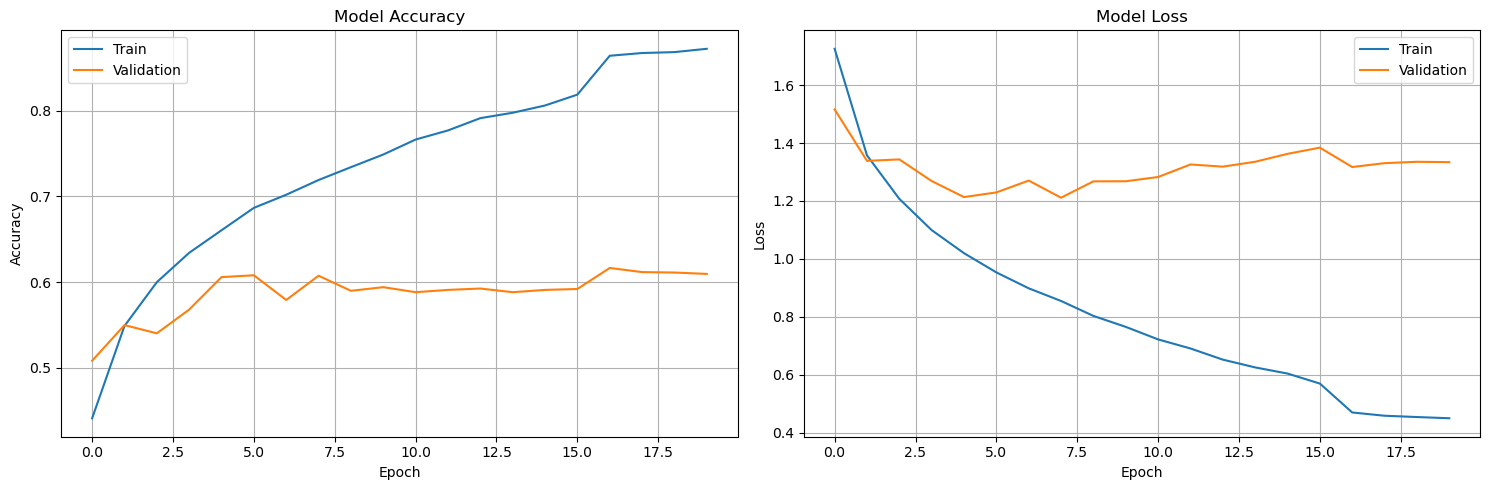

Best validation model: epoch 17  - val_accuracy 0.6165333390235901


In [17]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Model Accuracy ---
ax1.plot(h1.history['accuracy'])
ax1.plot(h1.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# --- Plot 2: Model Loss ---
ax2.plot(h1.history['loss'])
ax2.plot(h1.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# --- Your code for printing the best model can go here ---
best_idx = int(np.argmax(h1.history['val_accuracy']))
best_value = np.max(h1.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

### 2.3 Validation

In [18]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [19]:
model.load_weights(MODEL_NAME)
y_true, y_pred = [], []
for ann in val2:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

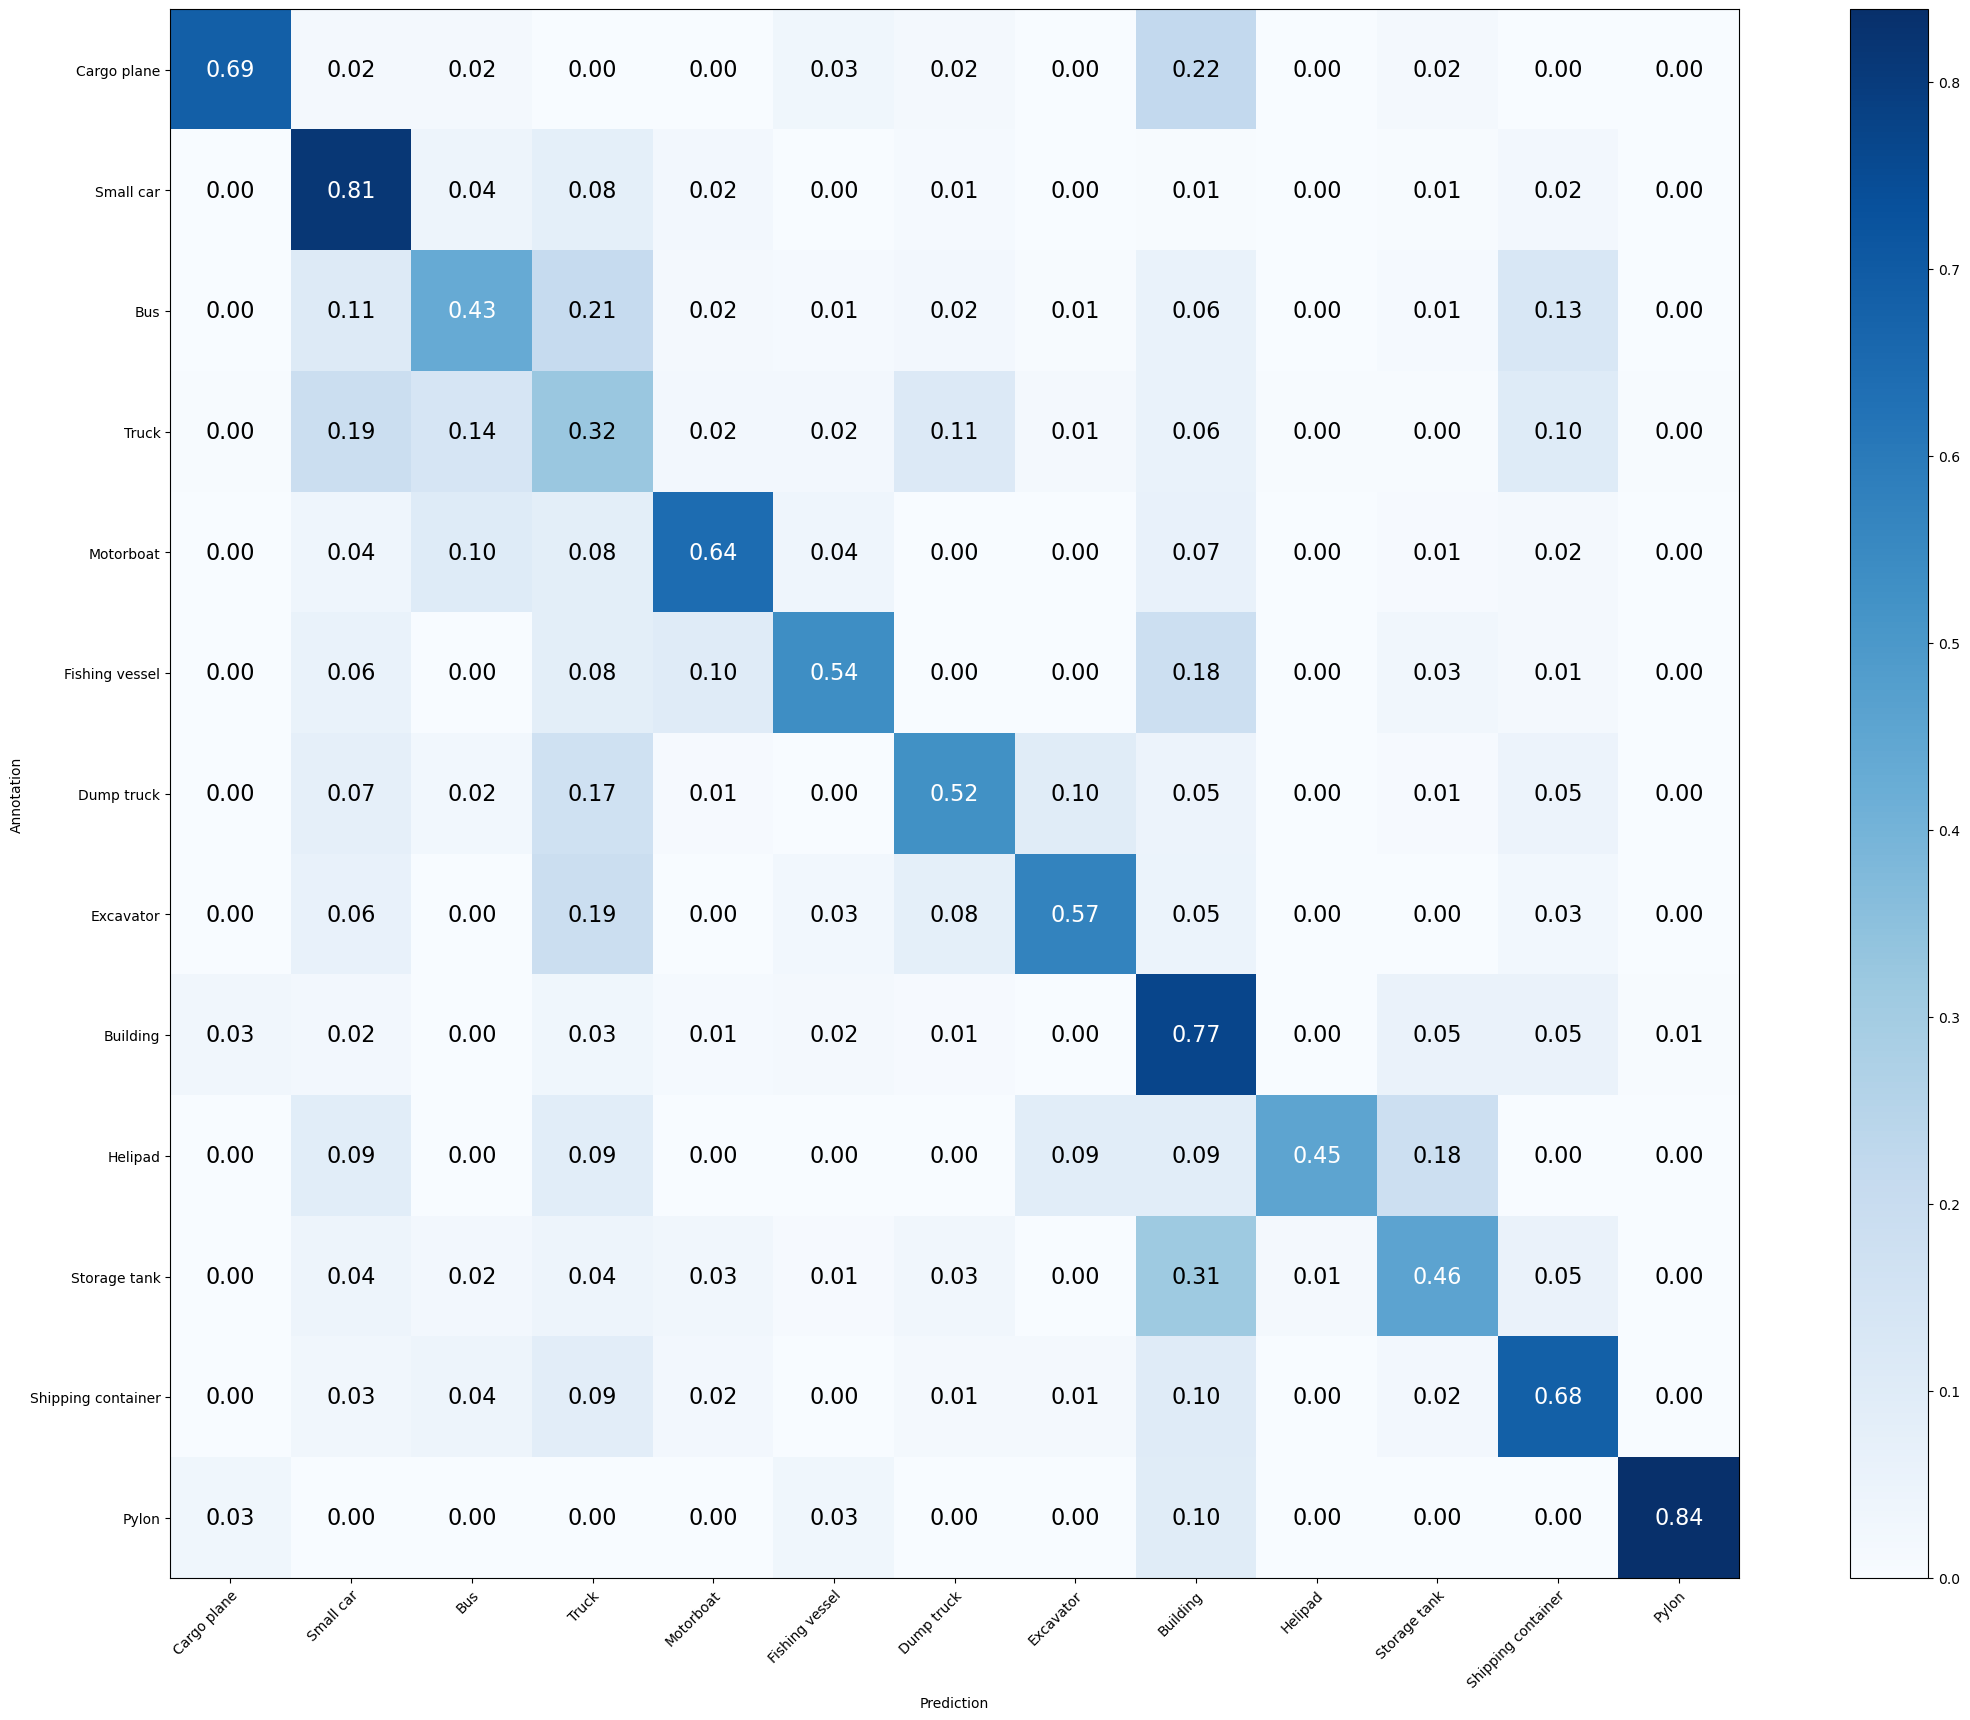

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [21]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 61.653%
Mean Recall: 59.441%
Mean Precision: 63.987%
> Cargo plane: Recall: 68.750% Precision: 78.571% Specificity: 99.337% Dice: 73.333%
> Small car: Recall: 81.325% Precision: 72.581% Specificity: 93.390% Dice: 76.705%
> Bus: Recall: 42.938% Precision: 52.055% Specificity: 95.878% Dice: 47.059%
> Truck: Recall: 32.127% Precision: 32.870% Specificity: 91.233% Dice: 32.494%
> Motorboat: Recall: 64.486% Precision: 66.990% Specificity: 98.077% Dice: 65.714%
> Fishing vessel: Recall: 53.521% Precision: 62.295% Specificity: 98.725% Dice: 57.576%
> Dump truck: Recall: 52.419% Precision: 57.018% Specificity: 97.202% Dice: 54.622%
> Excavator: Recall: 56.962% Precision: 70.312% Specificity: 98.942% Dice: 62.937%
> Building: Recall: 76.880% Precision: 67.317% Specificity: 91.161% Dice: 71.782%
> Helipad: Recall: 45.455% Precision: 62.500% Specificity: 99.839% Dice: 52.632%
> Storage tank: Recall: 45.578% Precision: 66.337% Specificity: 98.032% Dice: 54.032%
> Shipping container:

### 2.4 Testing

In [22]:
anns = []
i = 0
for (dirpath, dirnames, filenames) in os.walk('/mnt/c/Users/didie/Desktop/main/MUIA/CV/Labs/Image_Recognition/xview_recognition/xview_test/'):
    for filename in filenames:
        image = GenericImage(dirpath + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [23]:
model.load_weights(MODEL_NAME)
predictions_data = {"images": {}, "annotations": {}}

for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage("/".join(ann.filename.split('/')[-3:]))
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

FileNotFoundError: [Errno 2] No such file or directory: 'ffNN_model.keras'

In [ ]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)